In [93]:
import pandas as pd
import geocoder
import json
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

%matplotlib inline

In [31]:
spb_clear_data_path = "C:/Users/user/Documents/GitHub/SpbZeroVision/Data/SpbData/ClearData/"
spb_processing_data_path = "C:/Users/user/Documents/GitHub/SpbZeroVision/Data/SpbData/ProcessingData/"

In [6]:
dtp_info_df = pd.read_csv(spb_clear_data_path + "spb_main_info.csv")

In [14]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [30]:
geocoded_cards = []
for card in log_progress(dtp_info_df.iterrows(),10):
    row = card[1]
    r = geocoder.yandex(str(row.n_p) + " " + str(row.street) + " " + str(row.house))
    
    geocoded_card = r.json
    
    if(geocoded_card):
        geocoded_card['KartId'] = row['KartId']
    else:
        geocoded_card = {}
    
    geocoded_cards.append(geocoded_card)

Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', port=443): Max retries exceeded with url: /1.x/?geocode=%D0%B3+%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3+%D1%83%D0%BB+%D0%A1%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0+28&lang=en-US&kind=&format=json&results=1 (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x000001A2D2237E80>, 'Connection to geocode-maps.yandex.ru timed out. (connect timeout=5.0)'))
Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', por

In [34]:
with open(spb_processing_data_path + "geocod_dtp_cards.json", 'w', encoding='utf-8') as out_file:
    json.dump(geocoded_cards, out_file)

In [46]:
#check original coords and geocoded coogez
geocoded_cards_simple = [
    {
        "KartId": g['KartId'] if 'KartId' in g else 0,
        "accuracy": g['accuracy'] if 'accuracy' in g else '',
        "lat": g['lat'] if 'lat' in g else 0,
        "lng": g['lng'] if 'lng' in g else 0,
    }
for g in geocoded_cards]

geocoded_coords_df = pd.DataFrame(geocoded_cards_simple)
geocoded_coords_df.to_csv(spb_processing_data_path + "geocoeded_dtp_coords.csv", encoding='utf-8')

In [43]:
dtp_cards_df = pd.read_csv(spb_clear_data_path + 'spb_main_info.csv', encoding='utf-8')

In [142]:
geocoded_coords_join_df = dtp_cards_df.merge(geocoded_coords_df, how='left', on='KartId')

In [55]:
#geocoded_coords_join_df = geocoded_coords_join_df[['KartId', 'COORD_L', 'COORD_W', 'accuracy', 'lat','lng']]

In [76]:
null_gecoded_coords_df = geocoded_coords_join_df[geocoded_coords_join_df.accuracy.isnull()]

In [80]:
null_gecoded_coords_df[['n_p', 'street', 'house', 'COORD_L', 'COORD_W']]

,n_p,street,house,COORD_L,COORD_W
184,г Санкт-Петербург,наб Обводного канала,д.29ул.кре,30.374444,59.915556
362,г Санкт-Петербург,наб Синопская,мост об об,30.391389,59.923333
1021,п Шушары,пр-кт Витебский,1 км в сторону Шушар,30.399200,59.766100
1207,г Пушкин,дор На Александровку,NaN,30.358333,59.725833
1227,г Пушкин,ул Оранжерейная,Малая ул.,30.241944,59.432778
1327,п Шушары,ш Колпинское,дор.на ДСК,30.000000,59.000000
1344,г Пушкин,ул Оранжерейная,Малая ул.,30.405833,59.717778
1359,п Стрельна,NaN,78,30.254200,59.845800
1518,г Ломоносов,тер Жилгородок N15,15,29.433611,59.541111
1979,г Санкт-Петербург,ул Седова,28,30.414200,59.894400


In [65]:
geocoded_coords_join_df['check_dist'] = geocoded_coords_join_df.iloc[0:10].apply(lambda r: math.sqrt((r.COORD_L - float(r.lng))**2 + (r.COORD_W - float(r.lat))**2), axis=1)

In [95]:
geocoded_coords_join_df = geocoded_coords_join_df[['KartId','COORD_L','COORD_W', 'lat', 'lng']]

In [97]:
geocoded_coords_join_df.head()

,KartId,COORD_L,COORD_W,lat,lng
0,188969603,30.3483,59.9375,59.937197,30.347776
1,188970314,30.4694,59.8617,59.934042,30.347615
2,188970296,30.3350,59.9261,59.930746,30.342
3,188969607,30.3342,59.9475,59.946329,30.330618
4,188969605,30.3578,59.9372,59.936106,30.356822


In [115]:
#Получить точки вне границ города
spb_boundaries_gdf = gpd.read_file('../Gis/layers/spb_city_boundary.geojson')

In [120]:
spb_boundaries_gdf = spb_boundaries_gdf.drop([1,2])

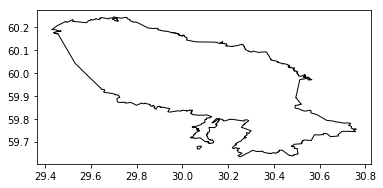

In [121]:
spb_boundaries_gdf.plot(color='white', edgecolor='black')

In [98]:
geometry = [Point(xy) for xy in zip(dtp_cards_df.COORD_L, dtp_cards_df.COORD_W)]
df = dtp_cards_df.drop(['COORD_L', 'COORD_W'], axis=1)
crs = {'init': 'epsg:4326'}
dtp_gdf = GeoDataFrame(df, crs=crs, geometry=geometry)

In [122]:
dtp_city_inetersection_gdf = dtp_gdf['geometry'].intersection(spb_boundaries_gdf)

In [130]:
spb_boundaries_gdf.intersection(dtp_gdf).describe()

count     21033
unique        2
top          ()
freq      21032
dtype: object

In [138]:
is_dtp_in_boundaries = dtp_gdf.intersects(spb_boundaries_gdf.unary_union)

In [143]:
geocoded_coords_join_df['in_city_boundaries'] = is_dtp_in_boundaries

In [144]:
geocoded_coords_join_df.to_csv('../Data/SpbData/ProcessingData/geocoded_dt.csv')

,Unnamed: 0,COORD_L,COORD_W,DTP_V,District,K_TS,K_UCH,KartId,POG,RAN,...,n_p,osv,rowNum,s_dtp,s_pch,street,accuracy,lat,lng,in_city_boundaries
0,0,30.3483,59.9375,Столкновение,Центральный район,2,3,188969603,0,1,...,г Санкт-Петербург,Светлое время суток,1,40,Сухое,пр-кт Литейный,exact,59.937197,30.347776,True
1,1,30.4694,59.8617,Столкновение,Центральный район,2,2,188970314,0,1,...,г Санкт-Петербург,Сумерки,2,140,Сухое,пр-кт Литейный,exact,59.934042,30.347615,True
2,2,30.3350,59.9261,Наезд на стоящее ТС,Центральный район,2,3,188970296,0,2,...,г Санкт-Петербург,"В темное время суток, освещение включено",3,70,Гололедица,наб Реки Фонтанки,exact,59.930746,30.342,True
3,3,30.3342,59.9475,Наезд на пешехода,Центральный район,1,2,188969607,0,1,...,г Санкт-Петербург,Светлое время суток,4,740,Мокрое,наб Дворцовая,near,59.946329,30.330618,True
4,4,30.3578,59.9372,Наезд на пешехода,Центральный район,1,2,188969605,0,1,...,г Санкт-Петербург,"В темное время суток, освещение включено",5,820,Сухое,ул Жуковского,exact,59.936106,30.356822,True
